In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
rho = 0.05
num_epochs = 30
train_log = []
test_log = []

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

## Задание 1. Обновить формулу KL-дивиргенции в соответствии со слайдами.

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p)) = 
                                                        = -p * log(q) - (1 - p) * log(1- q)
        """
        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho) # simplified DKL formula
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
model_sig = Net(64)

In [7]:
def train(epoch, model, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        rho_loss = model.rho_loss(rho)
        loss = model.loss(output, data) + rho_loss
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            train_loss = '{:.6f}'.format(model._loss.item())
            print(line + train_loss)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        train_loss = '{:.6f}'.format(model._loss.item())
        if log:
            log.append((models._loss, models._rho_loss))
        print(line + train_loss)

In [8]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'Rho loss: {:.4f}'.format(p)
line = lambda l, p: avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(model, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = 0
    rho_loss = 0
    with torch.no_grad():
        for data, _ in loader:
            output = model(data)
            test_loss += model.loss(output, data, size_average=False).item() # sum up batch loss
            rho_loss += model.rho_loss(rho, size_average=False).item()
    
    test_loss /= (test_size * 784)
    rho_loss /= (test_size * model.latent_size)
    if log:
        log.append((test_loss, pho_loss))
    
    lines = '\n'.join([line(test_loss, rho_loss)]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, num_epochs + 1):
    model_sig.train()
    train(epoch, model_sig, train_log)
    model_sig.eval()
    test(model_sig, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Loss 1.013797
Train Epoch: 1 [10000/50000 (20%)]	Loss 0.718026
Train Epoch: 1 [20000/50000 (40%)]	Loss 0.436343
Train Epoch: 1 [30000/50000 (60%)]	Loss 0.353737
Train Epoch: 1 [40000/50000 (80%)]	Loss 0.314591
Train Epoch: 1 [50000/50000 (100%)]	Loss 0.295151
Test set:
Loss: 0.2892	Rho loss: 0.0059

Train Epoch: 2 [0/50000 (0%)]	Loss 0.299490
Train Epoch: 2 [10000/50000 (20%)]	Loss 0.269462
Train Epoch: 2 [20000/50000 (40%)]	Loss 0.248989
Train Epoch: 2 [30000/50000 (60%)]	Loss 0.236520
Train Epoch: 2 [40000/50000 (80%)]	Loss 0.233764
Train Epoch: 2 [50000/50000 (100%)]	Loss 0.216742
Test set:
Loss: 0.2083	Rho loss: 0.0053

Train Epoch: 3 [0/50000 (0%)]	Loss 0.201969
Train Epoch: 3 [10000/50000 (20%)]	Loss 0.201188
Train Epoch: 3 [20000/50000 (40%)]	Loss 0.187682
Train Epoch: 3 [30000/50000 (60%)]	Loss 0.167990
Train Epoch: 3 [40000/50000 (80%)]	Loss 0.167745
Train Epoch: 3 [50000/50000 (100%)]	Loss 0.152064
Test set:
Loss: 0.1696	Rho loss: 0.0049

Train E

In [10]:
data, _ = next(iter(test_loader))
output = model_sig(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model_sig.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model_sig.E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = model_sig.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 3,  3,  3,  2,  3,  2,  4,  0,  3,  2,  3,  3,  2,  4,
         2,  2,  2,  3,  2,  1,  2,  3,  2,  2,  2,  4,  3,  2,
         4,  2,  3,  2,  5,  5,  2,  4,  3,  2,  2,  2,  2,  1,
         2,  1,  2,  1,  2,  0,  5,  4])


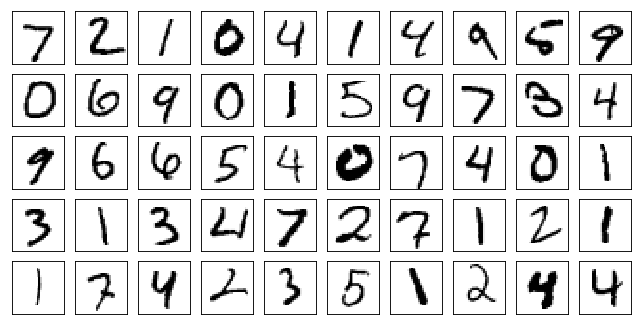

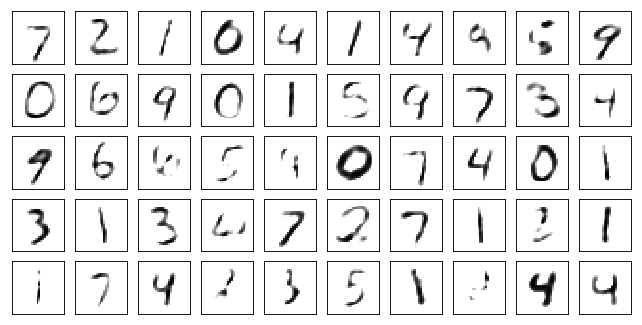

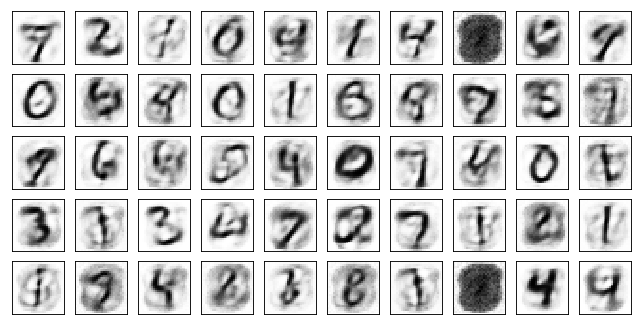

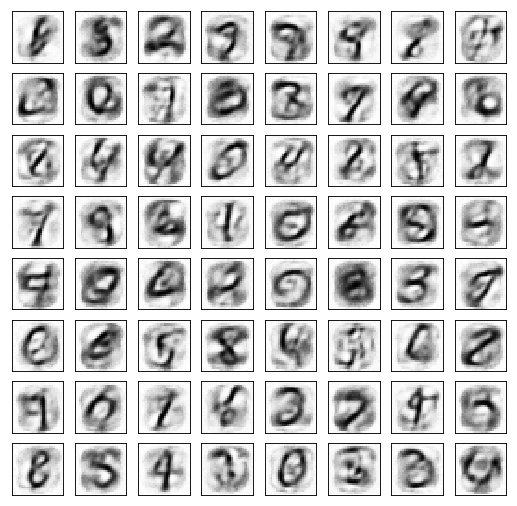

In [11]:
# images for sigmoid + KLD

plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

## Задание 2. Заменить sigmoid+KL на tanh+L1 и проверить, работает ли такой подход.

In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [13]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self.lambd = 0.05 # L1 regularization parameter
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.l1_term = torch.abs(h).sum()
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)

    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [14]:
model_tanh = Net(64)

In [15]:
def train(epoch, model, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, data) + model.lambd * model.l1_term / train_loader.batch_size
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            train_loss = '{:.6f}'.format(model._loss.item())
            print(line + train_loss)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        train_loss = '{:.6f}'.format(model._loss.item())
        print(line + train_loss)

In [16]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
l1_lambda = lambda p: 'L1 norm: {:.4f}'.format(p)
line = lambda l, p: avg_lambda(l) + '\t' + l1_lambda(p)
    
def test(model, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = 0
    with torch.no_grad():
        for data, _ in loader:
            output = model(data)
            test_loss += model.loss(output, data, size_average=False).item() # sum up batch loss
    
    test_loss /= (test_size * 784)
    
    lines = '\n'.join([line(test_loss, model.l1_term)]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [17]:
for epoch in range(1, num_epochs + 1):
    model_tanh.train()
    train(epoch, model_tanh, train_log)
    model_tanh.eval()
    test(model_tanh, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Loss 1.003195
Train Epoch: 1 [10000/50000 (20%)]	Loss 0.876676
Train Epoch: 1 [20000/50000 (40%)]	Loss 0.704051
Train Epoch: 1 [30000/50000 (60%)]	Loss 0.497199
Train Epoch: 1 [40000/50000 (80%)]	Loss 0.443657
Train Epoch: 1 [50000/50000 (100%)]	Loss 0.390873
Test set:
Loss: 0.3992	L1 norm: 343.3132

Train Epoch: 2 [0/50000 (0%)]	Loss 0.405806
Train Epoch: 2 [10000/50000 (20%)]	Loss 0.361169
Train Epoch: 2 [20000/50000 (40%)]	Loss 0.365796
Train Epoch: 2 [30000/50000 (60%)]	Loss 0.328695
Train Epoch: 2 [40000/50000 (80%)]	Loss 0.324615
Train Epoch: 2 [50000/50000 (100%)]	Loss 0.320671
Test set:
Loss: 0.3324	L1 norm: 233.3693

Train Epoch: 3 [0/50000 (0%)]	Loss 0.335880
Train Epoch: 3 [10000/50000 (20%)]	Loss 0.331503
Train Epoch: 3 [20000/50000 (40%)]	Loss 0.302642
Train Epoch: 3 [30000/50000 (60%)]	Loss 0.313463
Train Epoch: 3 [40000/50000 (80%)]	Loss 0.325173
Train Epoch: 3 [50000/50000 (100%)]	Loss 0.316283
Test set:
Loss: 0.3078	L1 norm: 186.8820

Trai

In [18]:
data, _ = next(iter(test_loader))
output = model_tanh(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model_tanh.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
decoded_neg = model_tanh.decode(torch.eye(64) * -1)
dec_to_plot_neg = ((decoded_neg.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model_tanh.E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.2).sum(1))
    encoded[torch.abs(encoded) < 0.2] = 0.
    decoded_f = model_tanh.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 1,  0,  1,  1,  1,  1,  0,  0,  0,  1,  2,  0,  1,  1,
         2,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  0,  1,  1,  2,  1,  1,  1,  0,  1,  1,  1,
         1,  1,  1,  0,  1,  0,  2,  1])


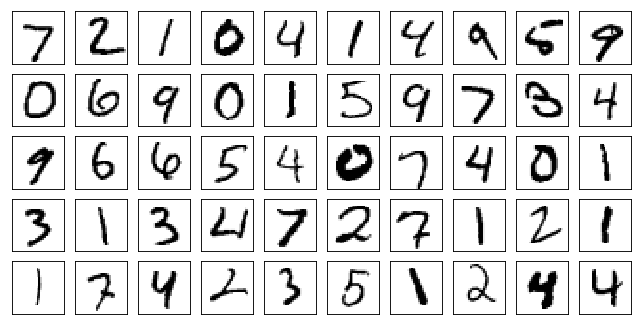

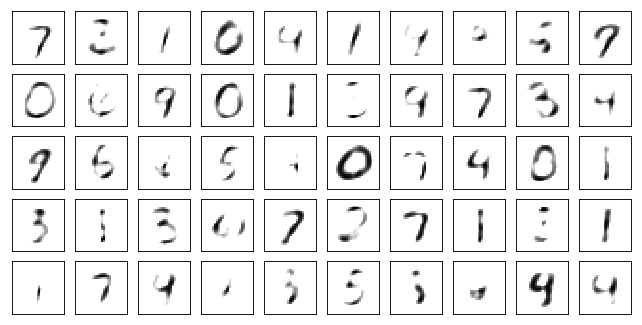

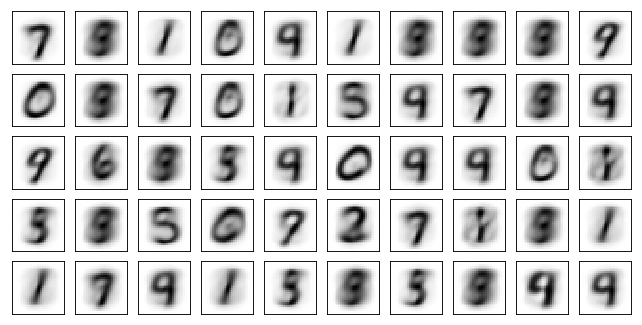

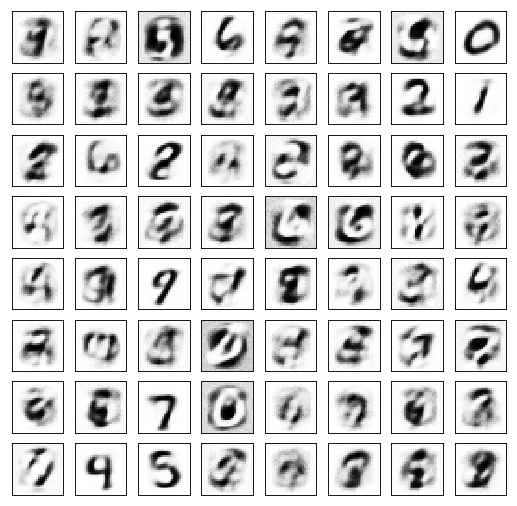

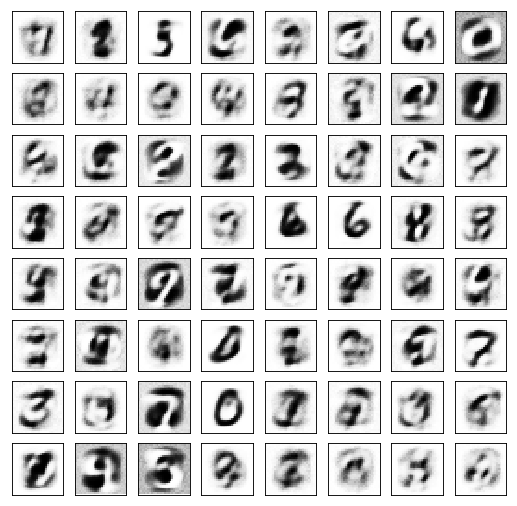

In [19]:
# images for tanh + L1

plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))
plot_mnist(dec_to_plot_neg, (8, 8))

## Задание 3. Используя дополнительный оптимайзер, подобрать на обученной сети картинку, на которой энкодер выдаст желаемый вектор латентного слоя, и сравнить с тем, что выдает декодер.

In [144]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [145]:
img, _ = next(iter(test_loader))
img = nn.Parameter(img)
img_opt = optim.Adam(params=[img], lr=1e-4)

Loss: 0.0011749101


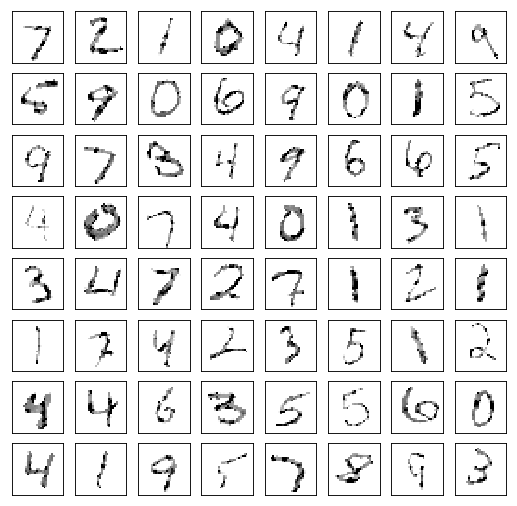

Loss: 0.0000175905


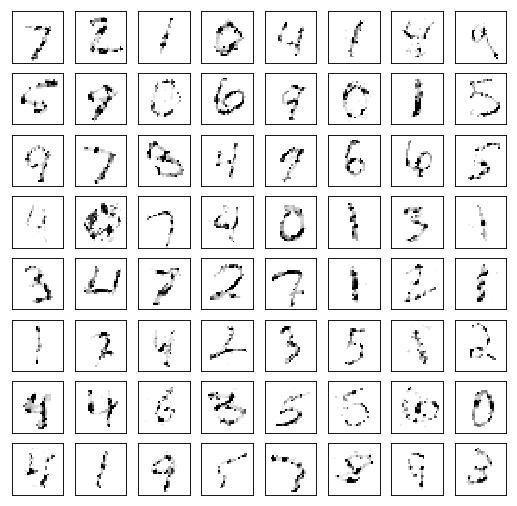

Loss: 0.0000020679


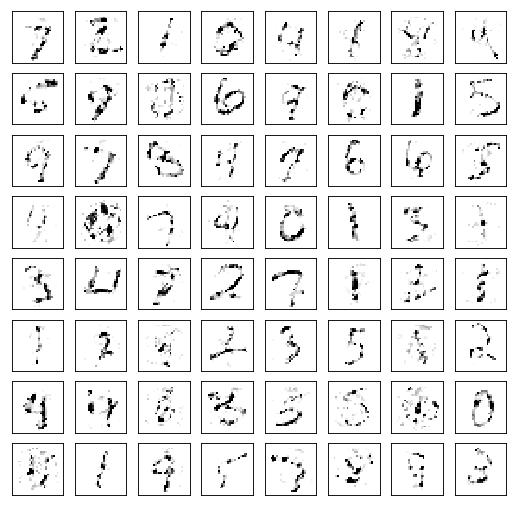

Loss: 0.0000010520


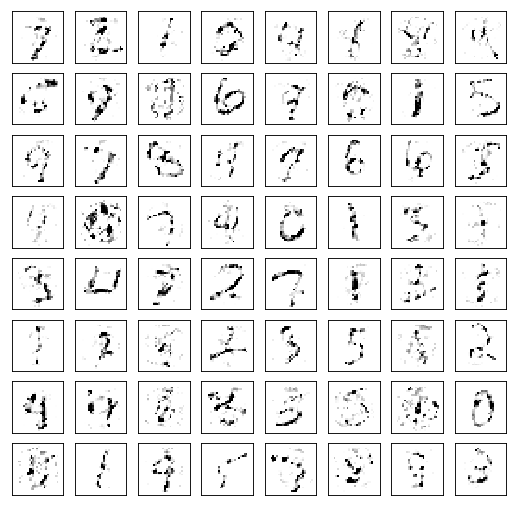

Loss: 0.0000007221


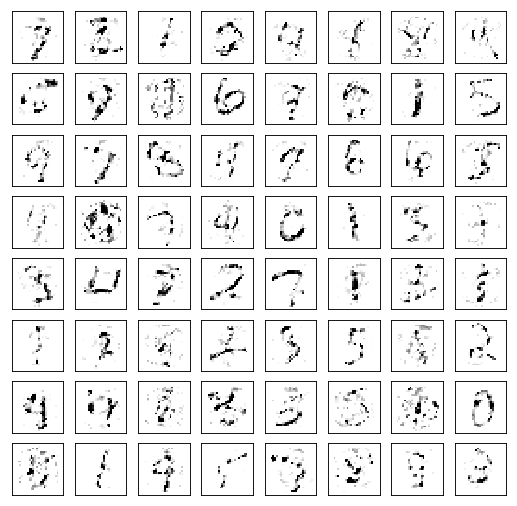

Loss: 0.0000005518


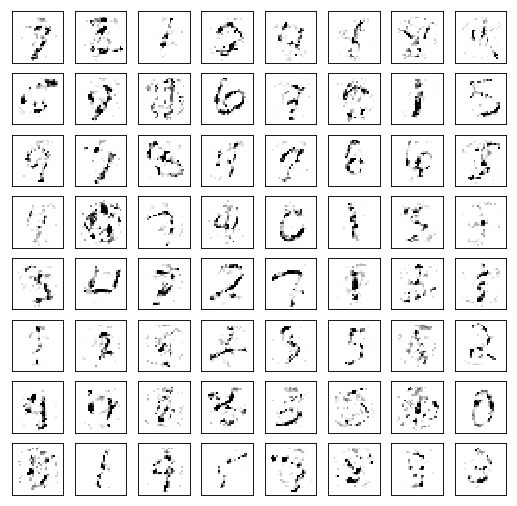

Loss: 0.0000004472


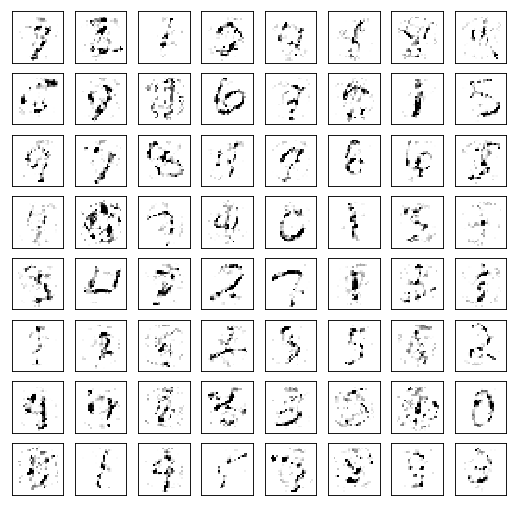

Loss: 0.0000003762


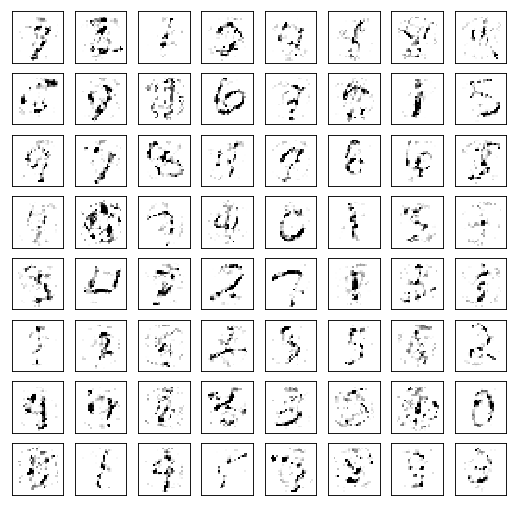

Loss: 0.0000003248


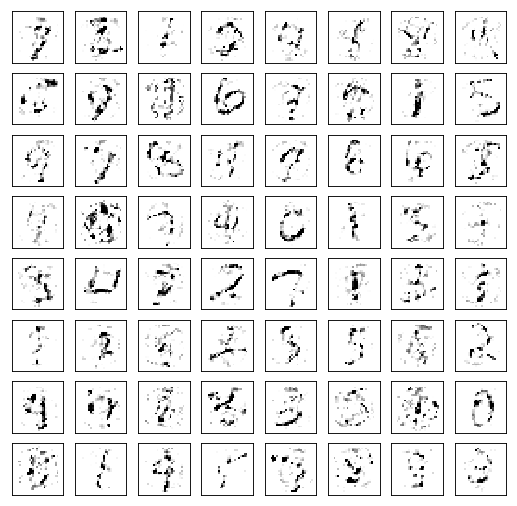

Loss: 0.0000002859


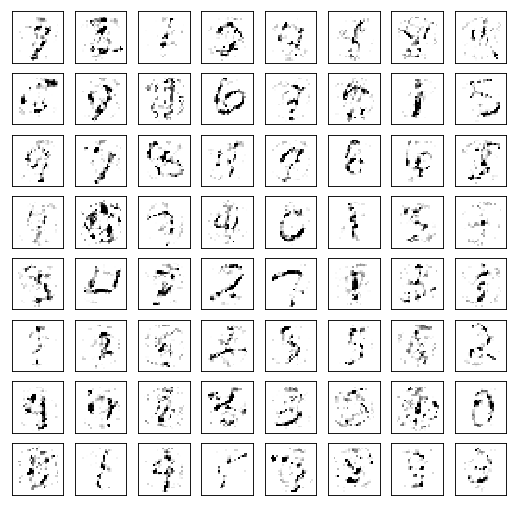

In [146]:
for i in range(1, 100001):
    img_opt.zero_grad()
    encoded = model_sig.E(img.view(-1, 28 * 28))
    img_loss = F.mse_loss(encoded, torch.eye(64))
    img_loss.backward(retain_graph=True)
    img_opt.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss.item():.10f}')
        plot_mnist(img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy(), (8, 8))

In [163]:
encoded[:3]

tensor([[ 9.9836e-01,  4.6979e-04,  3.1985e-04,  5.8938e-04,  4.9283e-04,
          3.6375e-04,  2.4411e-05,  5.6350e-04,  5.4688e-04,  9.9543e-05,
          4.6491e-04,  3.1893e-04,  8.0527e-04,  6.4700e-04,  1.0947e-03,
          2.6525e-04,  5.8513e-04,  3.6885e-04,  6.8295e-04,  5.0388e-05,
          2.3015e-04,  2.5836e-04,  8.8435e-04,  4.0403e-04,  5.3832e-04,
          3.3930e-05,  4.3109e-04,  6.2098e-04,  1.8323e-05,  8.4121e-04,
          5.8724e-04,  2.9095e-04,  4.5458e-04,  8.7649e-04,  4.8635e-04,
          6.8679e-04,  1.4029e-04,  1.0003e-03,  1.3057e-04,  6.4572e-04,
          2.8113e-04,  6.7923e-04,  6.5511e-04,  6.8542e-04,  1.9846e-05,
          4.6112e-04,  4.9816e-04,  7.2431e-04,  3.0063e-04,  5.4650e-04,
          3.4718e-04,  5.5798e-04,  5.7081e-04,  6.8624e-04,  2.6016e-04,
          8.2634e-04,  3.3415e-04,  1.7067e-04,  3.6156e-04,  6.2262e-04,
          3.2913e-05,  3.4329e-05,  1.9369e-04,  6.9515e-04],
        [ 1.9717e-04,  9.9853e-01,  4.4196e-05,  2

In [162]:
encoded[:3].round()

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,

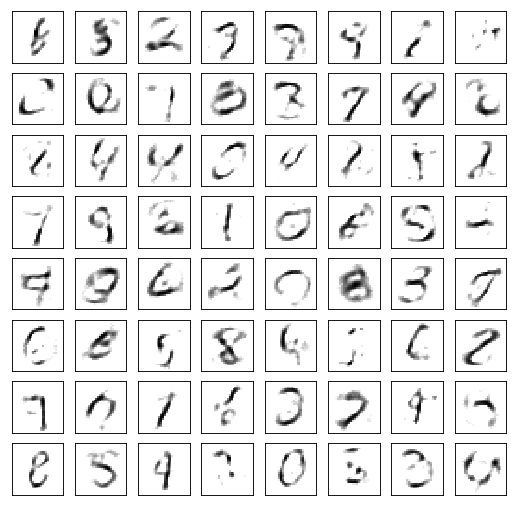

In [164]:
decoded = model_sig(img)
plot_mnist(decoded.view(-1, 1, 28, 28).clamp(0, 1).data.numpy(), (8, 8))